<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Side_Objective_Ticking_IPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Identify modes of IPI in recordings of ticking

In [2]:
import os
import librosa
import time
import seaborn as sns
from librosa import display
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import scipy
import csv
import random
from scipy import fftpack, signal
from scipy.ndimage import gaussian_filter1d
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft
import pandas as pd
from scipy.stats import norm, gaussian_kde

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


###Female-male Separation Pipeline

In [3]:
def clear_out(lower,upper,data,points_per_freq):
  target_idx_noise_lower = int(points_per_freq * lower)
  target_idx_noise_upper = int(points_per_freq * upper)
  data[: target_idx_noise_lower] = 0
  data[target_idx_noise_upper:] = 0
  
def fourier_transform(samples, sampling_rate):
  #fourier transform on audio file
  yf = rfft(samples)
  xf = rfftfreq(len(samples), 1 / sampling_rate)
  return xf,yf

#smooth the curve
def smooth_curve(randomlist_yf,sigma=40):
  #We get a smoother curve upon increasing the value of sigma.
  y_smoothed = gaussian_filter1d(randomlist_yf, sigma)
  peaks, _  = scipy.signal.find_peaks(y_smoothed)
  troughs, _  = scipy.signal.find_peaks(-y_smoothed)
  return peaks,troughs,y_smoothed

def peak_processing(peaks,randomlist_xf):
  #remove all peaks with xf value below 450, between 700 and 1600, and above 2500
  for i in peaks:
    if((randomlist_xf[i]<450) or
      #((randomlist_xf[i]>700) and (randomlist_xf[i]<1600))or
      (randomlist_xf[i]>2500)):
      peaks = np.delete(peaks,np.argwhere(peaks == i))
  peaks_list = randomlist_xf[peaks]
  return peaks_list

def trough_processing(troughs,randomlist_xf):
  #if the smallest trough that's below 450 is below 350  replace it with 350
  if(randomlist_xf[troughs].min()<350):
    troughs_list = np.where(randomlist_xf[troughs]<350,350,randomlist_xf[troughs])
  else:
    troughs_list = np.append([350], randomlist_xf[troughs], axis = 0)
  return troughs_list

def generate_boundaries(peaks_list,troughs_list):
  #getting the boundaries for the female call
  i = 0
  while(troughs_list[i] < peaks_list[0]):
    i+=1
  upper_bound_0 = troughs_list[i]
  lower_bound_0 = troughs_list[i-1]

  #getting the boundaries for the male call
  while(troughs_list[i] < peaks_list[1]):
    i+=1
  upper_bound_1 = troughs_list[i]
  #the lower bound of the male call: take the 
  #difference between the upper bound and the peak,
  #and use the peak value to subtract the difference
  difference = upper_bound_1 - peaks_list[1]
  lower_bound_1 = peaks_list[1] - difference
  #the lower bound of male call can't go below 1500Hz for
  #Xenopus Laevis or Xenopus Petersii
  if(lower_bound_1 < 1500):
    lower_bound_1 = 1500
  boundary_list = [150,lower_bound_0,upper_bound_0,lower_bound_1,3000]
  return boundary_list

def write_audio(samples,lowerlimit,upperlimit,points_per_freq,file_name,specific_name,sampling_rate=44100):
  yf_special = rfft(samples)
  clear_out(lowerlimit,upperlimit,yf_special,points_per_freq)
  new_sig = irfft(yf_special)
  write(file_name+specific_name,sampling_rate,new_sig)

In [4]:
def separation_for_IPI_calculating(file_path,sampling_rate=44100):
  file_name = os.path.basename(file_path)
  #load audio file
  samples, sampling_rate = librosa.load(file_path,sr=sampling_rate)

  #perform fourier transform on the data
  xf,yf = fourier_transform(samples, sampling_rate)

  #get the number of points per frequency
  points_per_freq = len(xf) / (sampling_rate / 2)

  #rough clean of data for smoothing
  clear_out(150,3000,yf,points_per_freq)

  #sample down audio file to 23274 data points
  randomlist = random.sample(list(range(0,(len(xf)-1))),23274)
  randomlist.sort()
  randomlist_xf = xf[randomlist]
  randomlist_yf = np.abs(yf)[randomlist]

  peaks,troughs,y_smoothed = smooth_curve(randomlist_yf)

  #data processing on the peaks and troughs
  peaks_list = peak_processing(peaks,randomlist_xf)
  troughs_list = trough_processing(troughs,randomlist_xf)

  boundary_list = generate_boundaries(peaks_list,troughs_list)

  #plot the graph
  
  plt.figure(figsize=(20,5))
  plt.plot(xf,np.abs(yf),color="grey")
  plt.plot(randomlist_xf,y_smoothed,color="red")
  plt.plot(randomlist_xf[peaks],y_smoothed[peaks],"x")
  plt.plot(randomlist_xf[troughs],y_smoothed[troughs],"o",color="green")
  plt.vlines(boundary_list,-10,3000,colors='black', linestyles='dashed')
  ticks = np.concatenate([np.arange(0, 4000, step=1000),boundary_list])
  ticks.sort()
  plt.xticks(ticks)
  plt.xlim((0,4000))
  plt.show()
  
  #obtain female signal
  yf_special = rfft(samples)
  clear_out(boundary_list[1],boundary_list[2],yf_special,points_per_freq)
  female = irfft(yf_special)

  #obtain noise signal
  yf_special = rfft(samples)
  clear_out(boundary_list[0],350,yf_special,points_per_freq)
  noise = irfft(yf_special)

  print('female lower bound: ',boundary_list[1])
  print('female higher bound: ',boundary_list[2])
  return female, noise

###Wave Envelope and Find Peaks

In [5]:
#get statistics on ticking IPI
def get_ticking_IPI_stats(peak_indices_list,x_time):
  IPI = []
  for i in range(0,len(peak_indices_list)-1):
    front = peak_indices_list[i]
    back = peak_indices_list[i+1]
    difference = x_time[back] - x_time[front]
    IPI.append(difference)
  #Assumption: Rapping is categorized by 3 or more consecutive pulses within 1 second.
  i=0
  IPI_processed = []
  while (i < (len(IPI)-2)):
  #while(0):
    if((IPI[i]+IPI[i+1])<4):
      IPI_processed.append(IPI[i])
      IPI_processed.append(IPI[i+1])
      k = 2
      while(1):
        if((IPI[i+k]<2)and(i+k <(len(IPI)-1))):
          IPI_processed.append(IPI[i+k])
          k=k+1
        else:
          i = i+k+1
          break
    else:
      i=i+1
  #generate statistics for rapping IPI plot
  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)

  IPI_processed = [i for i in IPI_processed if (i<median+2*std)]

  std = np.std(IPI_processed)
  mean = np.mean(IPI_processed)
  median = np.median(IPI_processed)
  return IPI_processed, mean, median, std

In [6]:
def IPI_calculation(file_path):
  female, noise = separation_for_IPI_calculating(file_path)
  hilbert_signal = abs(signal.hilbert(female))
  #time vector
  sampling_rate = 44100
  duration = len(hilbert_signal)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)
  threshold = 0.05*np.max(hilbert_signal)
  peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.05*44100)
  plt.figure(figsize=(20,5))
  plt.plot(x_time, hilbert_signal)
  plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
  #plt.xlim(40*44100, 41*44100)
  plt.show()

  IPI_processed,mean,median,std = get_ticking_IPI_stats(peaks,x_time)
  print("Mean: ", mean,"; Median: ",median, "; STD: ", std)

In [7]:
def female_bimodal_separation(file_path):
  female, noise = separation_for_IPI_calculating(file_path)
  hilbert_signal = abs(signal.hilbert(female))
  #time vector
  sampling_rate = 44100
  duration = len(hilbert_signal)/sampling_rate
  x_time = np.arange(0,duration,1/sampling_rate)
  threshold = 0.05*np.max(hilbert_signal)
  peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=threshold,distance=0.05*44100)
  '''
  plt.figure(figsize=(20,5))
  plt.plot(x_time, hilbert_signal)
  plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
  #plt.xlim(40*44100, 41*44100)
  plt.show()
  '''
  IPI_processed,mean,median,std = get_ticking_IPI_stats(peaks,x_time)
  df = pd.DataFrame (IPI_processed, columns = ['IPI_processed'])
  return df,IPI_processed

In [8]:
def female_bimodal_plot(file_path):
  file_name = os.path.basename(file_path)
  df, IPI_processed = female_bimodal_separation(file_path)
  ax = df.plot.kde()
  plt.close()
  line = ax.lines[0]
  x = line.get_xdata()
  y = line.get_ydata()

  peaks = scipy.signal.find_peaks(y)
  peaks = peaks[0]

  if(len(x[peaks]) > 1):
    figure,ax1 = plt.subplots()
    figure.suptitle(file_name, fontsize=16)
    ax1.hist(IPI_processed,bins=30,color='whitesmoke')
    ax1.set_ylabel('Count',fontsize=14,labelpad=10)
    figure.set_size_inches(10,7)

    ax2 = ax1.twinx()

    ax2.plot(x,y)
    ax2.plot(x[peaks],y[peaks],'x')
    ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
    ax2.set_ylabel('Density',fontsize=14,labelpad=10)

    Mode_1 = x[peaks][0]
    Mode_2 = x[peaks][1]

    ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
    ax2.text(Mode_2+0.01,0.5,s="Mode_2 = "+format(Mode_2, ".3f"),color='dimgrey')
    #ax2.text(0.22+0.01,1.5,s="Laevis ticking IPI (0.21-0.23)",color='darkgrey')

    ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
    ax2.axvline(Mode_2,linestyle="dashed",color="dimgrey")
    #ax2.axvline(0.22,linestyle="dashed",color="darkgrey")

    plt.savefig('/content/drive/MyDrive/Ticking_8_min/plots/'+file_name+'_plot.png',)
    plt.show()

    print("Mode_1: ", Mode_1)
    print("Mode_2: ", Mode_2)

  elif(len(x[peaks]) == 1):
    figure,ax1 = plt.subplots()
    figure.suptitle(file_name, fontsize=16)
    ax1.hist(IPI_processed,bins=30,color='whitesmoke')
    ax1.set_ylabel('Count',fontsize=14,labelpad=10)
    figure.set_size_inches(10,7)

    ax2 = ax1.twinx()

    ax2.plot(x,y)
    ax2.plot(x[peaks],y[peaks],'x')
    ax2.set_xlabel('Inter-Pulse Interval (s)',fontsize=14,labelpad=10)
    ax2.set_ylabel('Density',fontsize=14,labelpad=10)

    Mode_1 = x[peaks][0]

    ax2.text(Mode_1+0.01,0.5,s="Mode_1 = "+format(Mode_1, ".3f"),color='dimgrey')
    #ax2.text(0.22+0.01,1.5,s="Laevis ticking IPI (0.21-0.23)",color='darkgrey')

    ax2.axvline(Mode_1,linestyle="dashed",color="dimgrey")
    #ax2.axvline(0.22,linestyle="dashed",color="darkgrey")

    plt.show()

    print("Mode_1: ", Mode_1)
  else:
    print("This " + file_name + " have no modes")

###Execution

In [9]:
def plot_execution(species_name):
  for filename in os.listdir('/content/drive/MyDrive/Ticking_8_min'):
      if filename.startswith(species_name):
        female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/'+filename)

#####Laevis

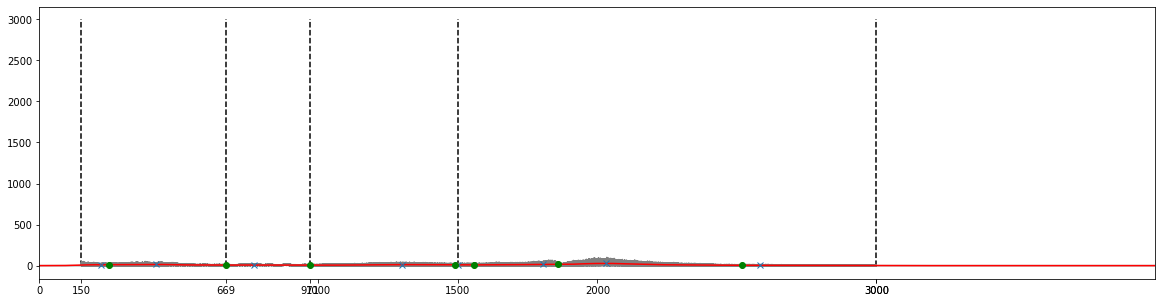

female lower bound:  668.5528485588214
female higher bound:  971.2003366836204


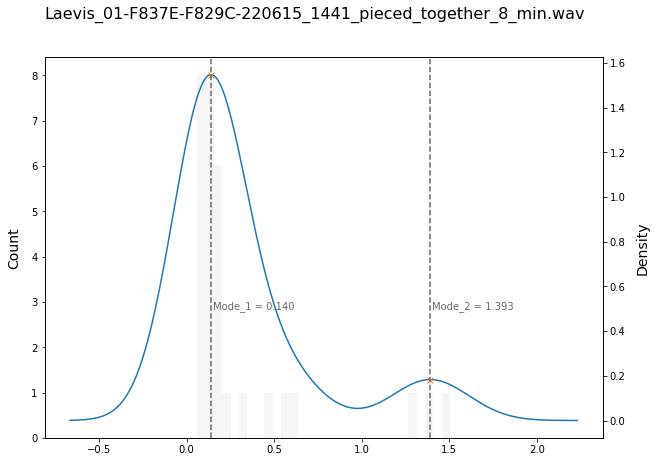

Mode_1:  0.1398841131380737
Mode_2:  1.3926830345084378


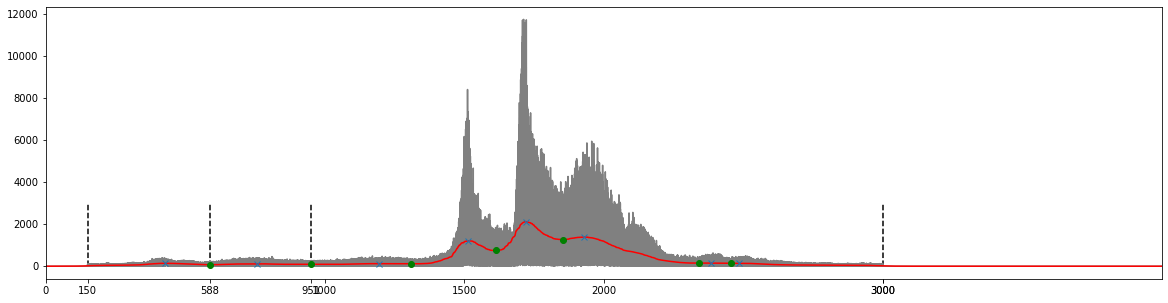

female lower bound:  587.567033052476
female higher bound:  950.7071322083192


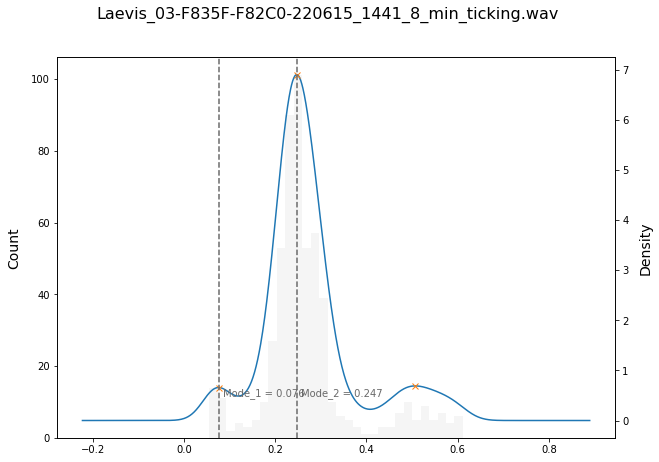

Mode_1:  0.07594237094236062
Mode_2:  0.24739954239953255


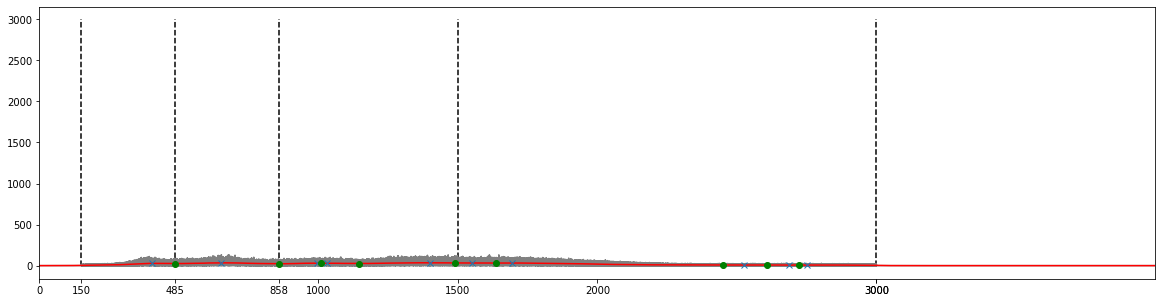

female lower bound:  485.19340028220597
female higher bound:  857.6198736167371


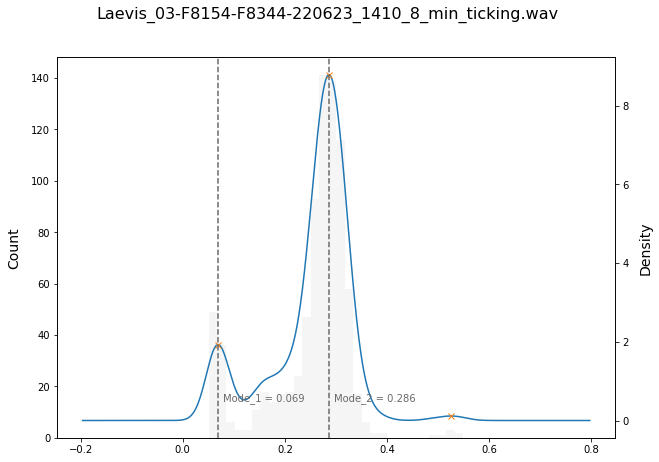

Mode_1:  0.06938063914253467
Mode_2:  0.28622324138196675


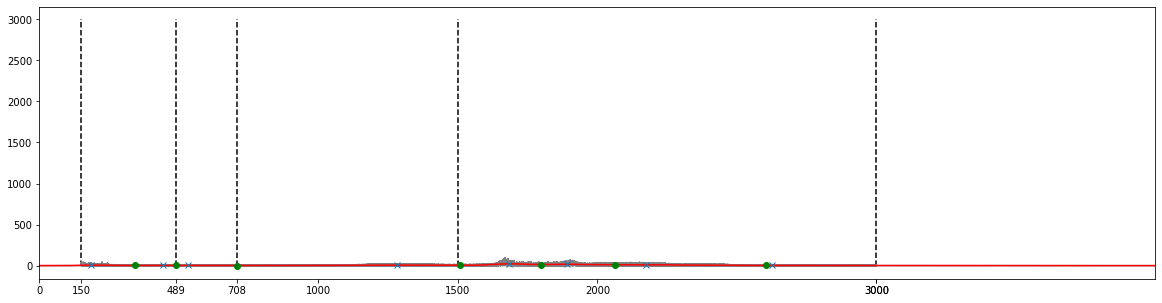

female lower bound:  489.19702557746695
female higher bound:  707.8925986330701


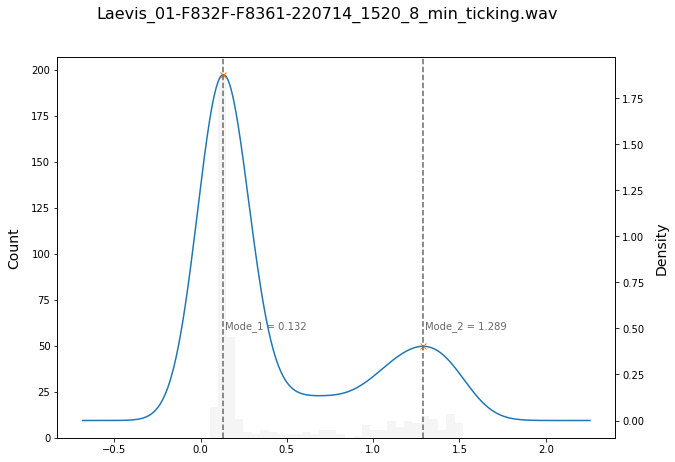

Mode_1:  0.13234485051945222
Mode_2:  1.2885289257511474


In [10]:
plot_execution('Laevis')

#####Petersii

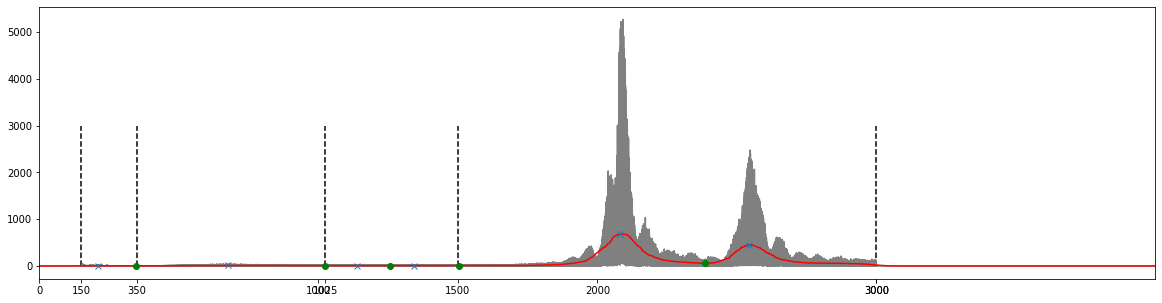

female lower bound:  350.0
female higher bound:  1025.3991110405295


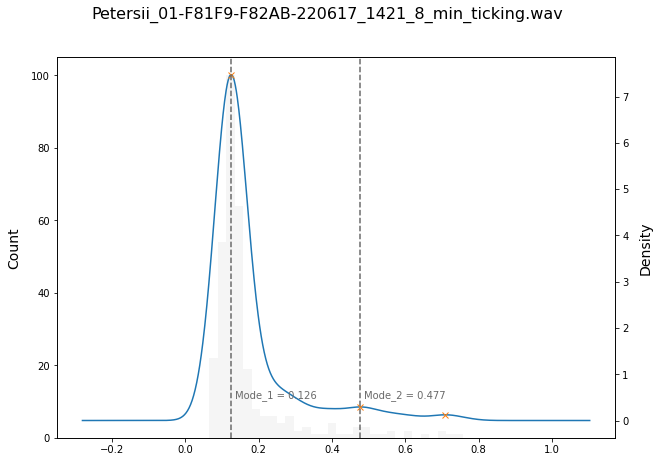

Mode_1:  0.1255107715425352
Mode_2:  0.4770850215294744


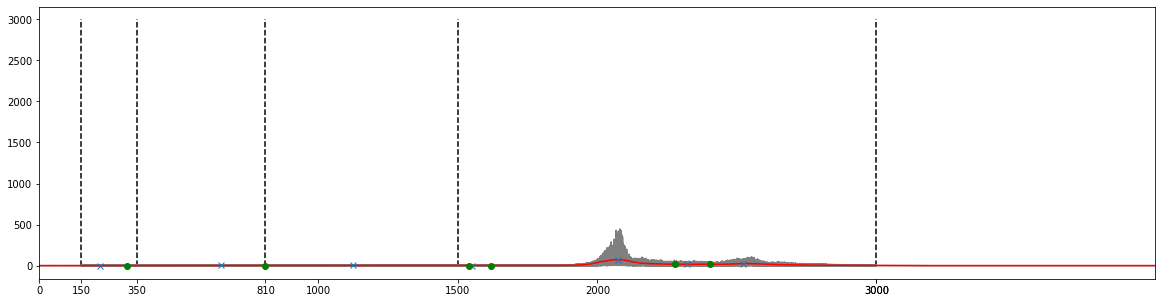

female lower bound:  350.0
female higher bound:  809.641166168719


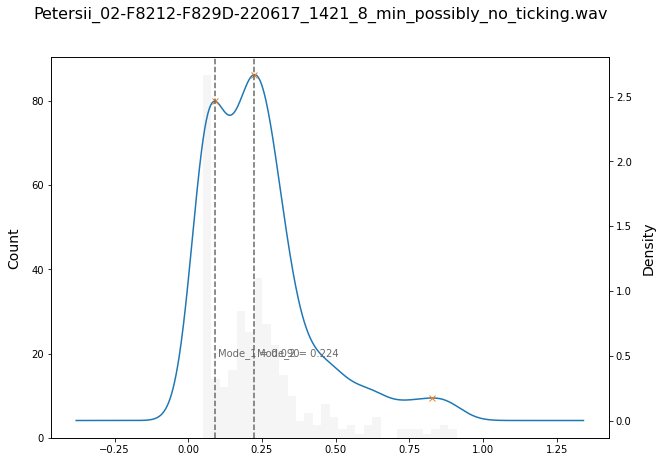

Mode_1:  0.09007960341294002
Mode_2:  0.2243880615309216


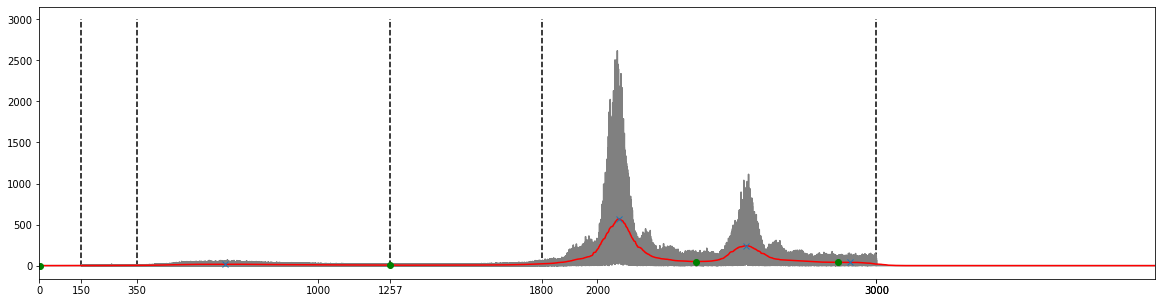

female lower bound:  350.0
female higher bound:  1257.0869512169131


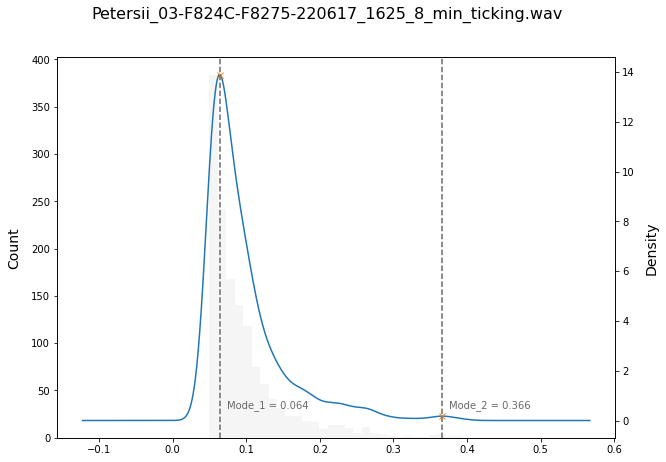

Mode_1:  0.06396212539069412
Mode_2:  0.36595772643391705


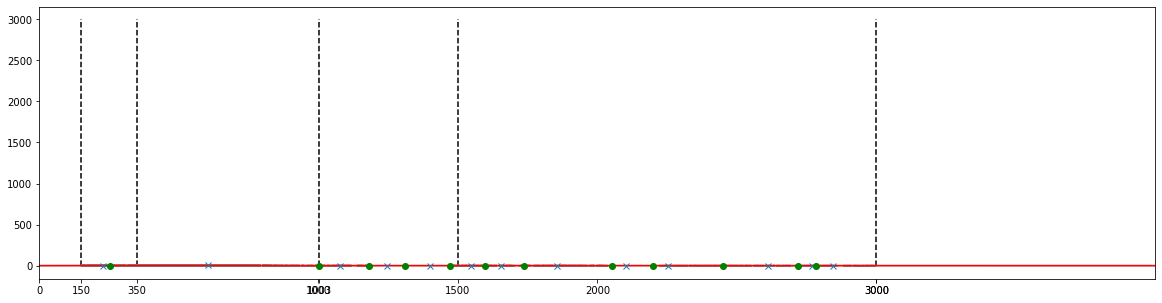

female lower bound:  350.0
female higher bound:  1002.5191266555887


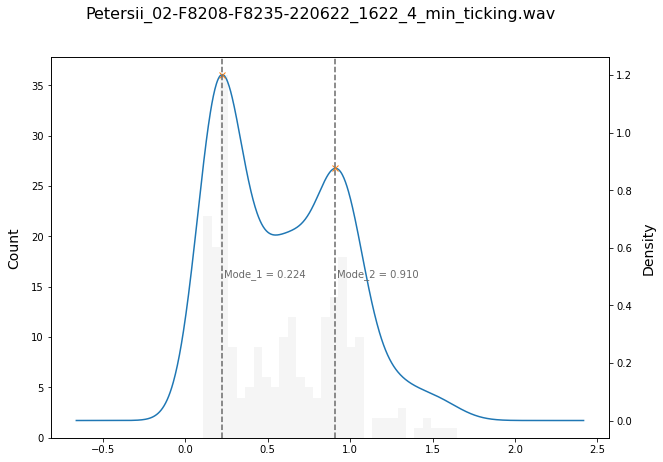

Mode_1:  0.2239694115884543
Mode_2:  0.9104643418929086


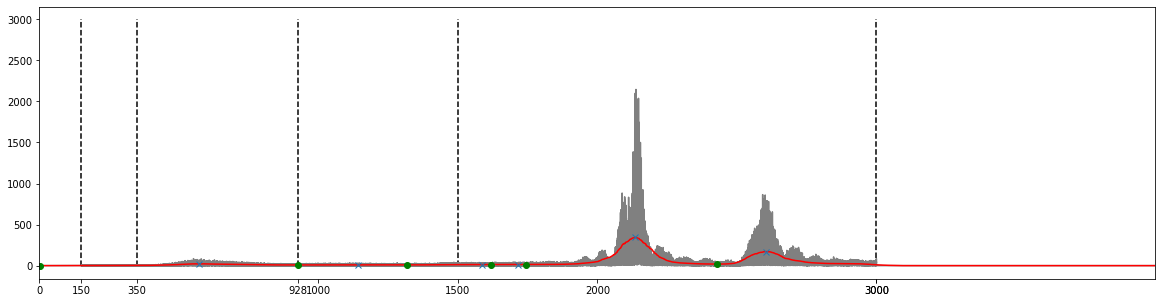

female lower bound:  350.0
female higher bound:  927.9584223641208


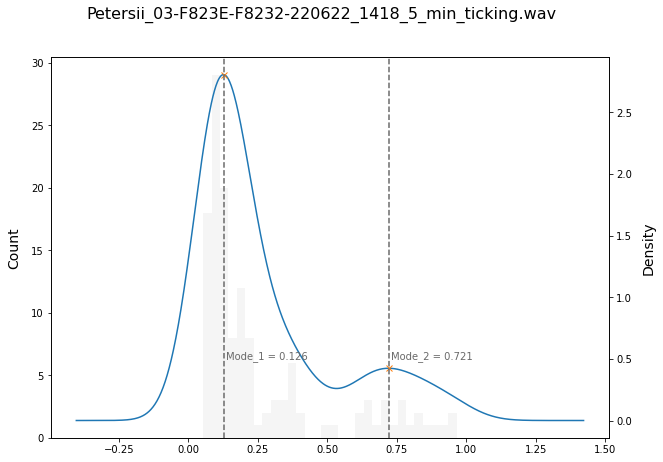

Mode_1:  0.12645847661721
Mode_2:  0.7205718643813945


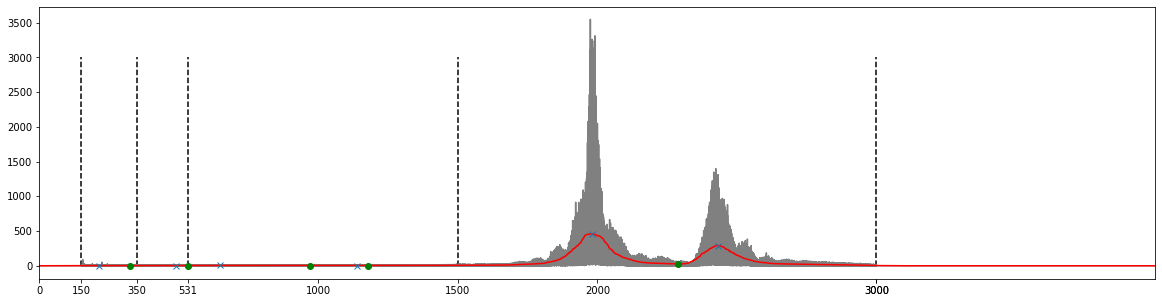

female lower bound:  350.0
female higher bound:  531.385916815335


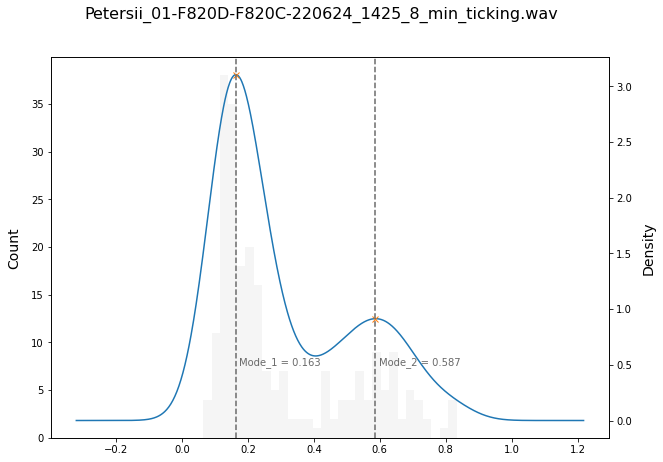

Mode_1:  0.16301032324841802
Mode_2:  0.5866346278251012


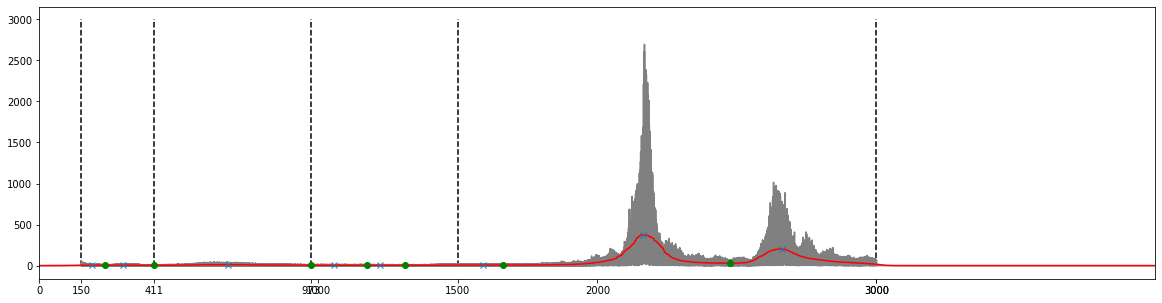

female lower bound:  411.3429543255844
female higher bound:  972.6350416653388


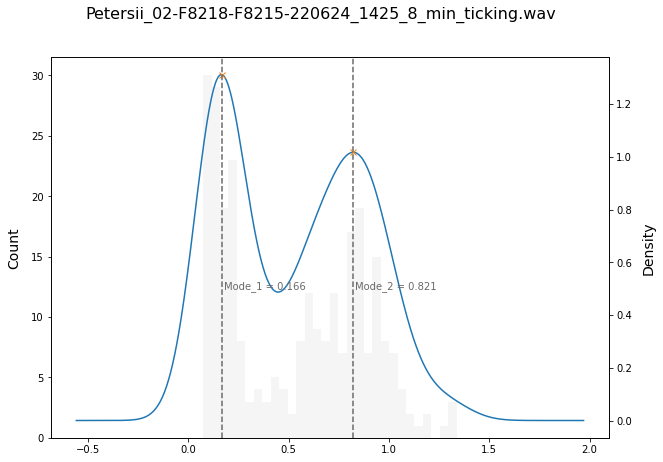

Mode_1:  0.16586756824850968
Mode_2:  0.8211762102238203


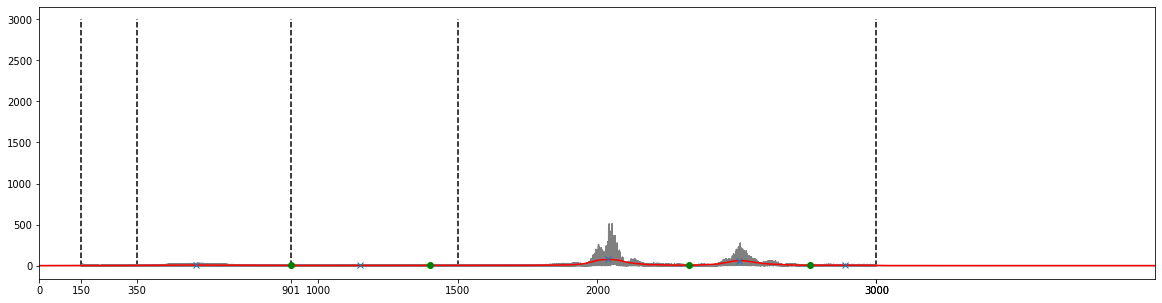

female lower bound:  350.0
female higher bound:  900.5013387951709


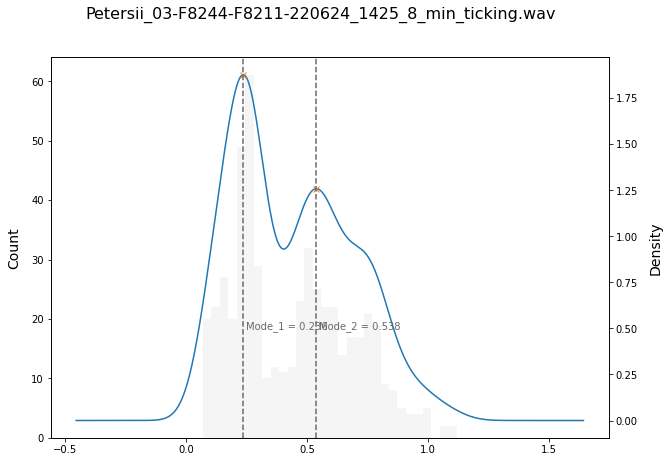

Mode_1:  0.2362357482198666
Mode_2:  0.5384154789710269


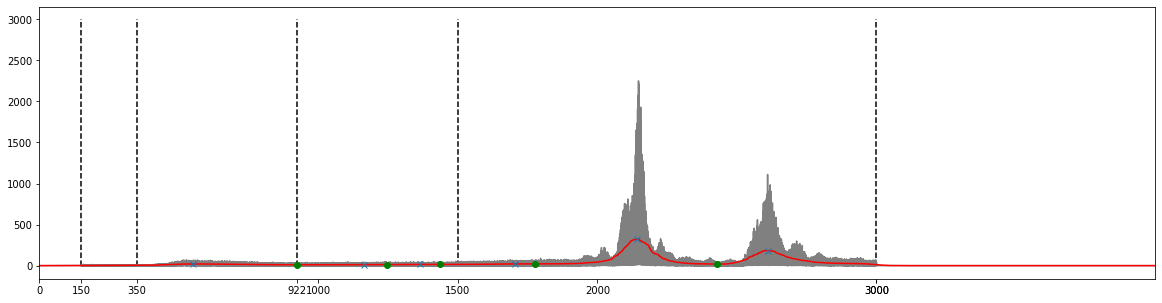

female lower bound:  350.0
female higher bound:  922.2349814933168


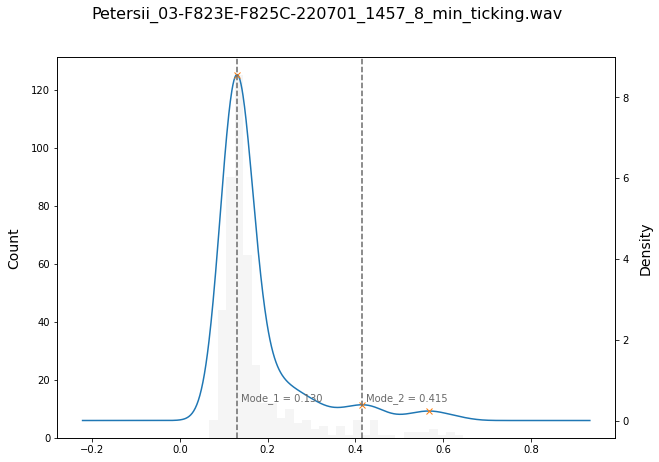

Mode_1:  0.12990825292412006
Mode_2:  0.41472749393384867


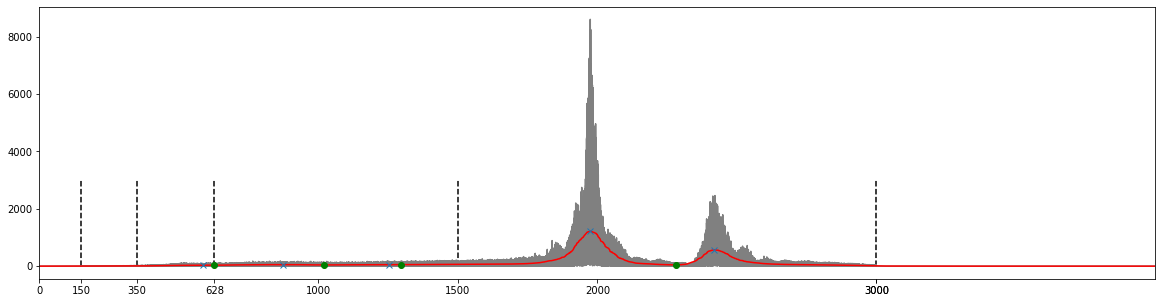

female lower bound:  350.0
female higher bound:  627.755591847235


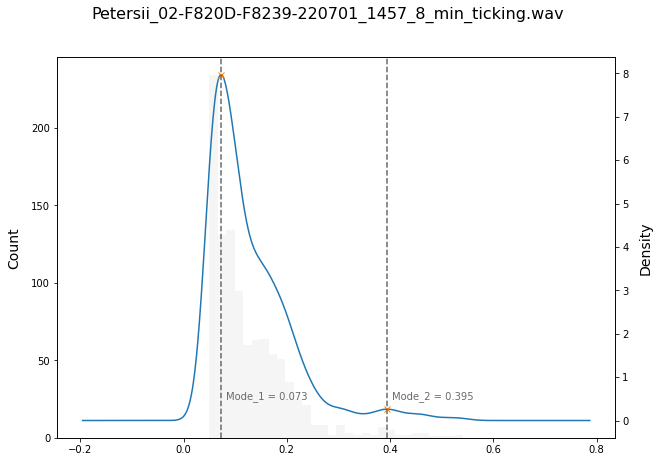

Mode_1:  0.07289064574778287
Mode_2:  0.39451757880330285


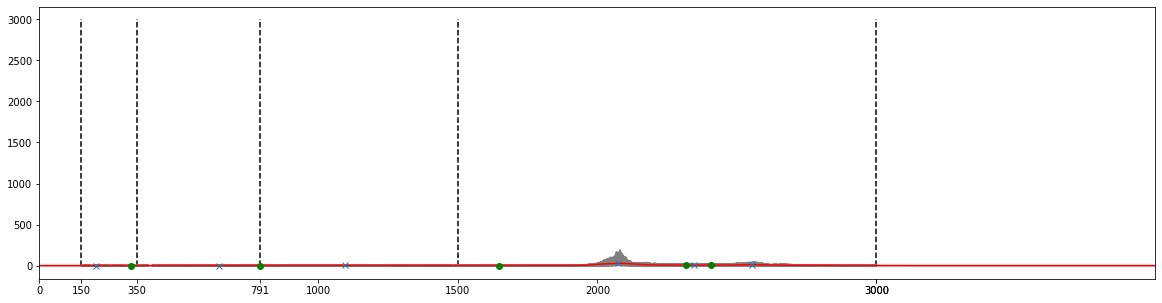

female lower bound:  350.0
female higher bound:  791.0115492210125


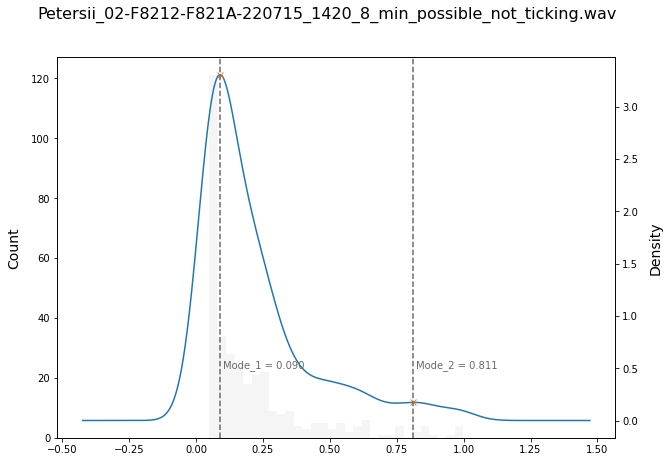

Mode_1:  0.09038504490886745
Mode_2:  0.8113481849196162


In [13]:
plot_execution('Petersii')

#####Vic

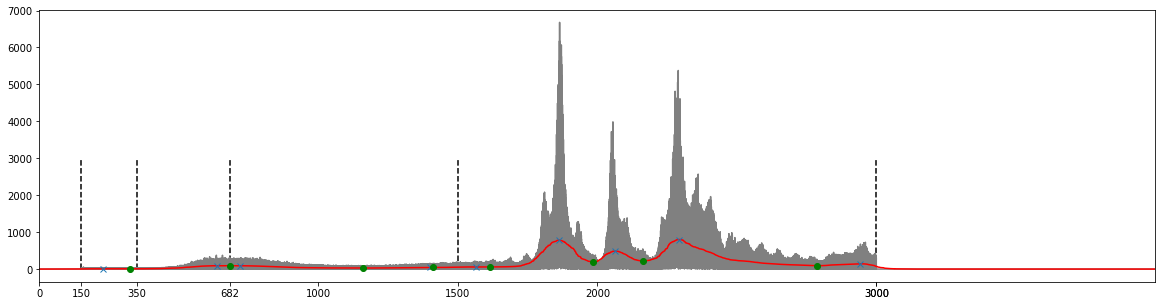

female lower bound:  350.0
female higher bound:  681.8111680159532


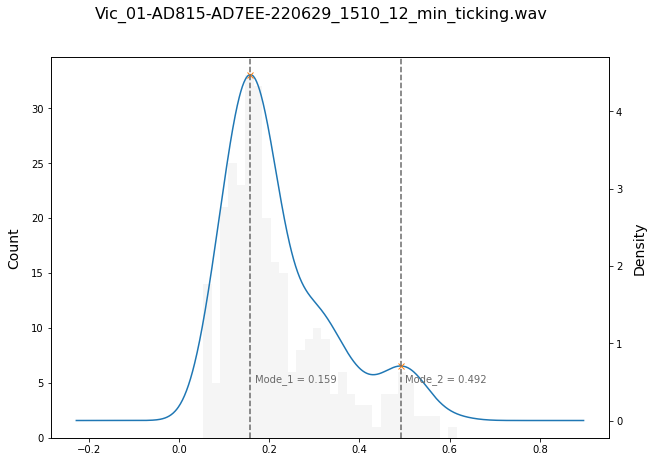

Mode_1:  0.15868002923555624
Mode_2:  0.4915665665665513


In [11]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Vic_01-AD815-AD7EE-220629_1510_12_min_ticking.wav')

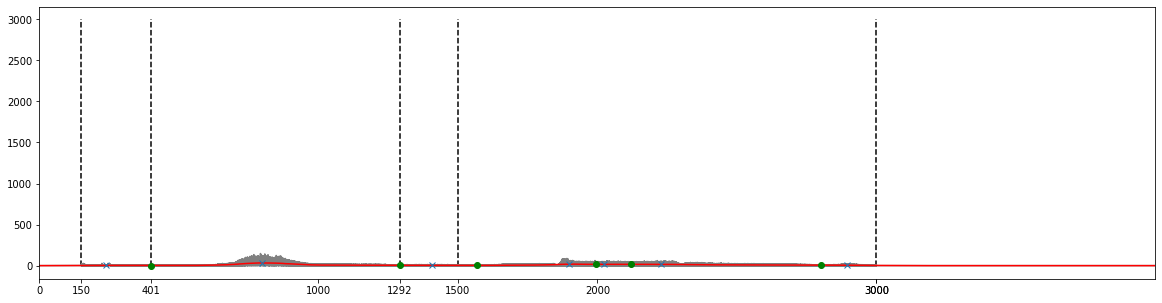

female lower bound:  400.988909078549
female higher bound:  1291.803120039684


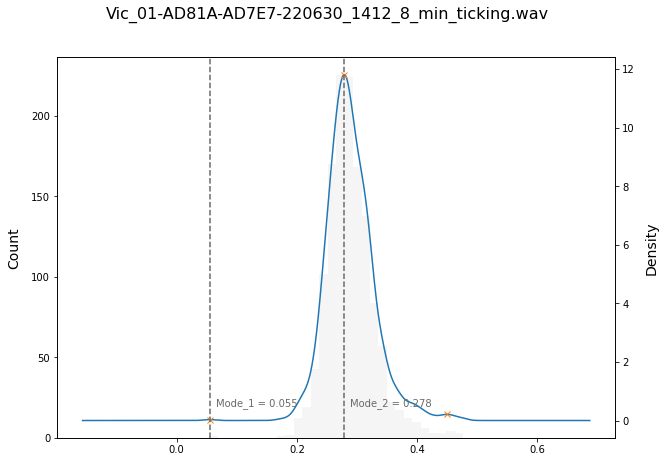

Mode_1:  0.05458761482570565
Mode_2:  0.27845706250467883


In [12]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Vic_01-AD81A-AD7E7-220630_1412_8_min_ticking.wav')

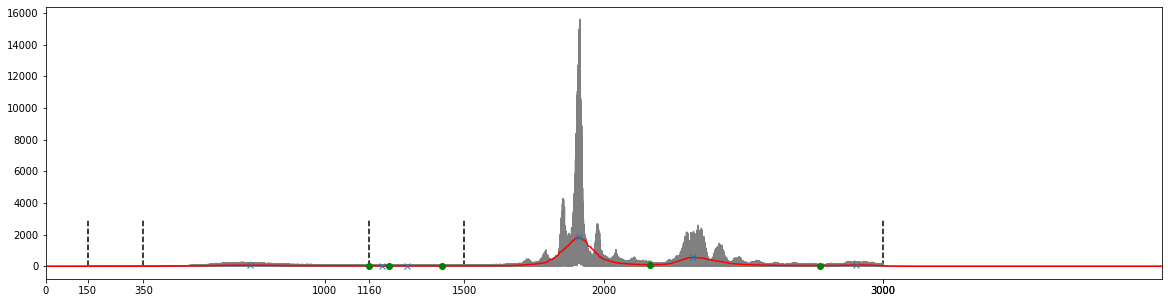

female lower bound:  350.0
female higher bound:  1160.419879337423


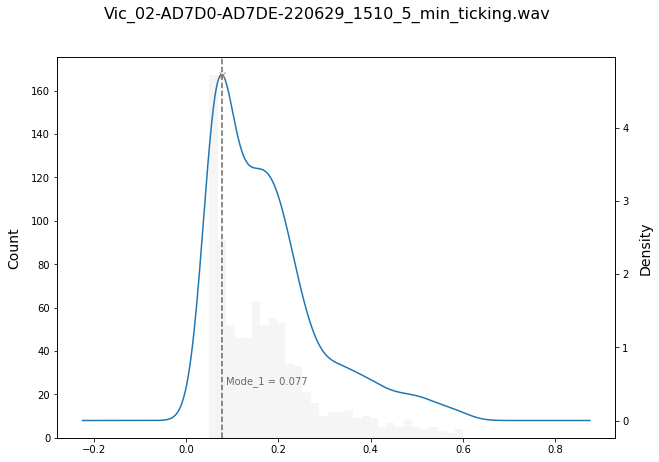

Mode_1:  0.07680231251659453


In [18]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Vic_02-AD7D0-AD7DE-220629_1510_5_min_ticking.wav')

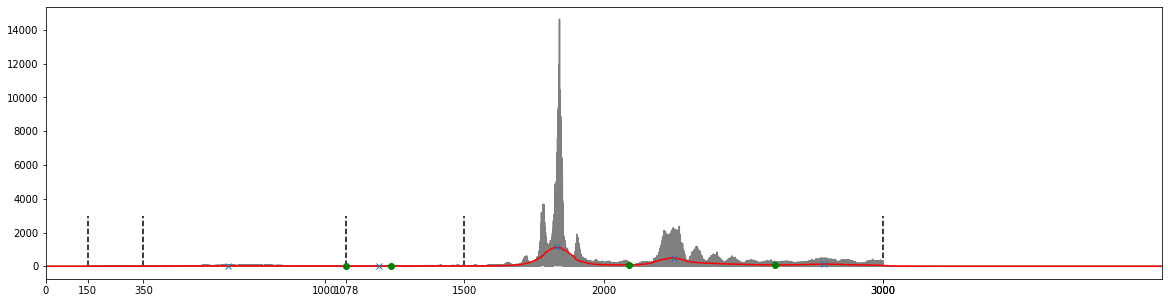

female lower bound:  350.0
female higher bound:  1077.9841560821712


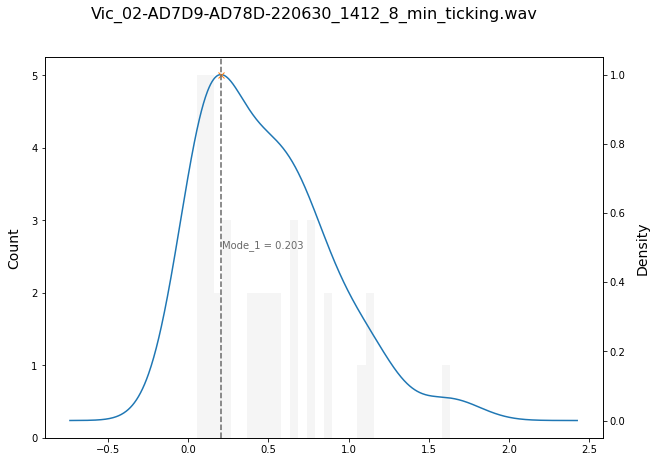

Mode_1:  0.20253048967334486


In [14]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Vic_02-AD7D9-AD78D-220630_1412_8_min_ticking.wav')

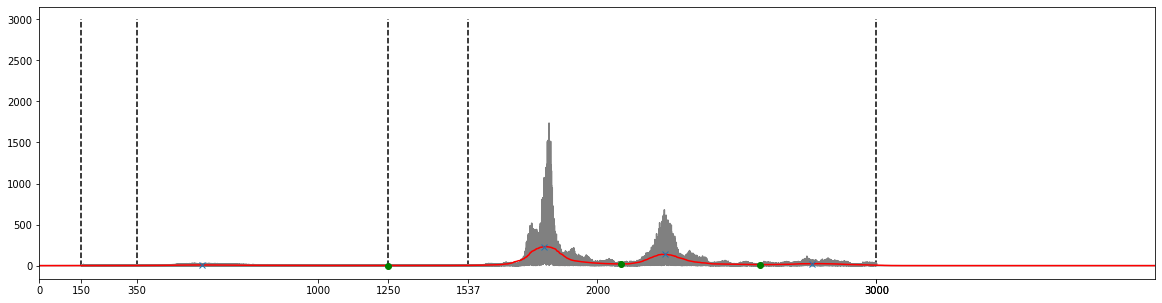

female lower bound:  350.0
female higher bound:  1249.6028190663287


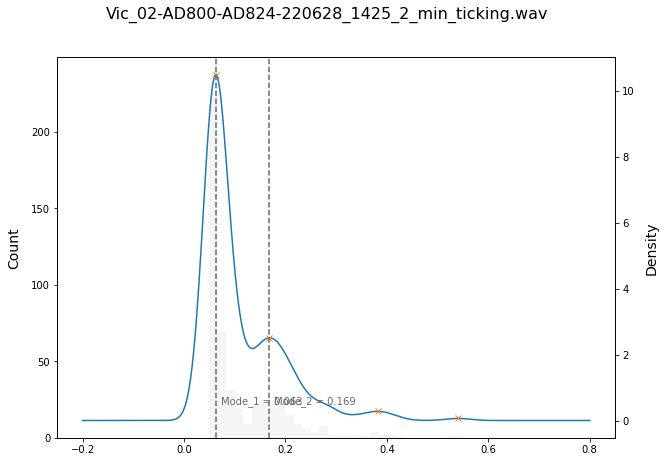

Mode_1:  0.06336178582210317
Mode_2:  0.1685288576558418


In [15]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Vic_02-AD800-AD824-220628_1425_2_min_ticking.wav')

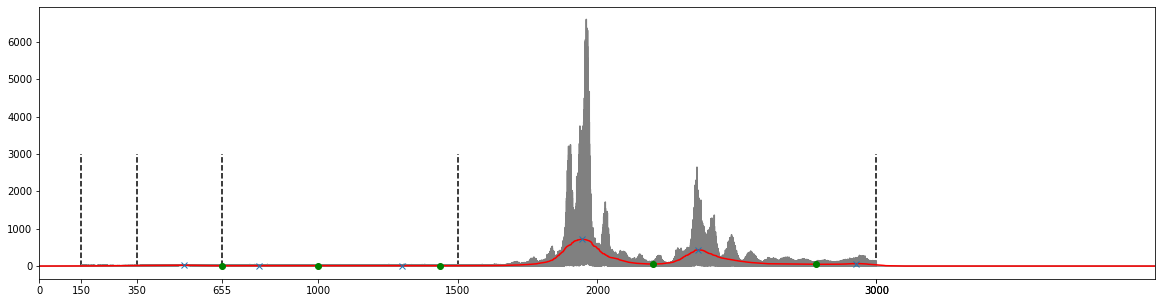

female lower bound:  350.0
female higher bound:  654.6684302290627


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: ignored

In [16]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Vic_03-AD7CA-AD81C-220629_1510_8_min_ticking.wav')

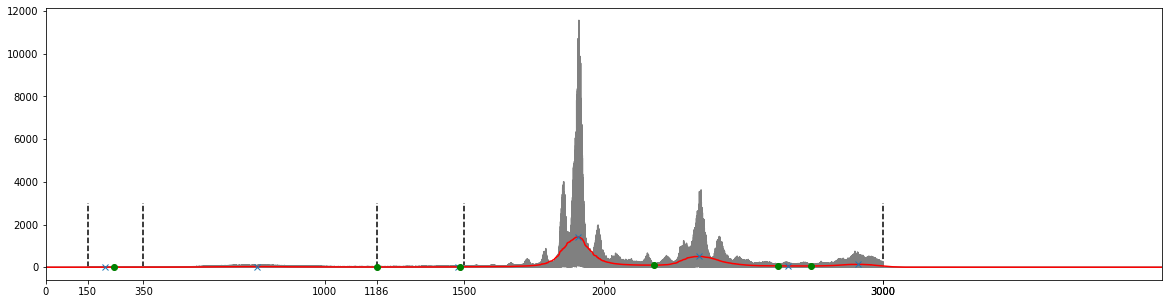

female lower bound:  350.0
female higher bound:  1186.0444734788125


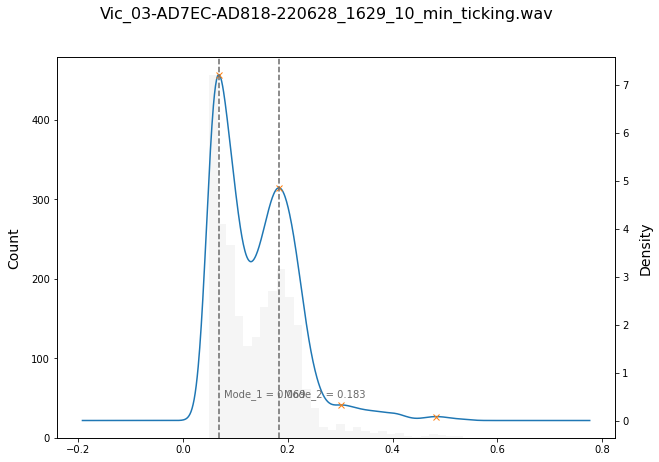

Mode_1:  0.0687246997564056
Mode_2:  0.18308767951622934


In [17]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Vic_03-AD7EC-AD818-220628_1629_10_min_ticking.wav')

#####Poweri

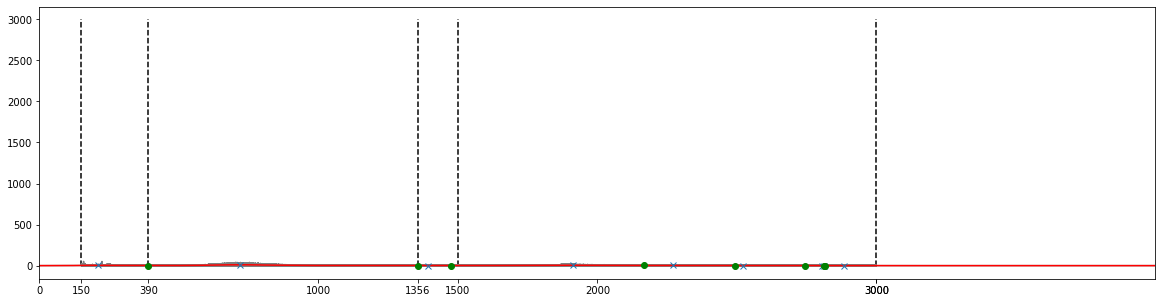

female lower bound:  390.0725696926891
female higher bound:  1356.0641528922326


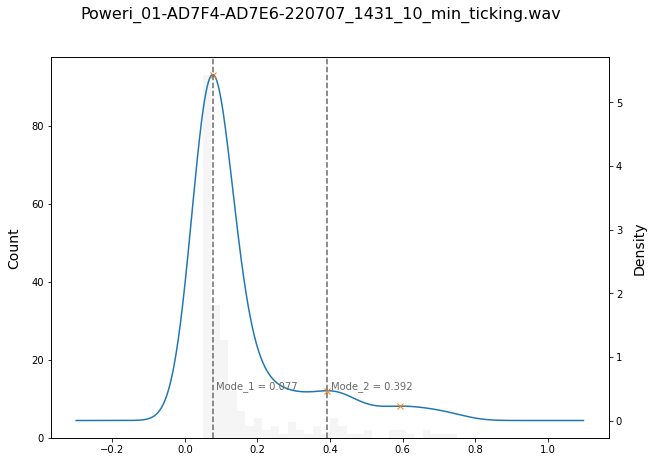

Mode_1:  0.07699082302258214
Mode_2:  0.39167285199031954


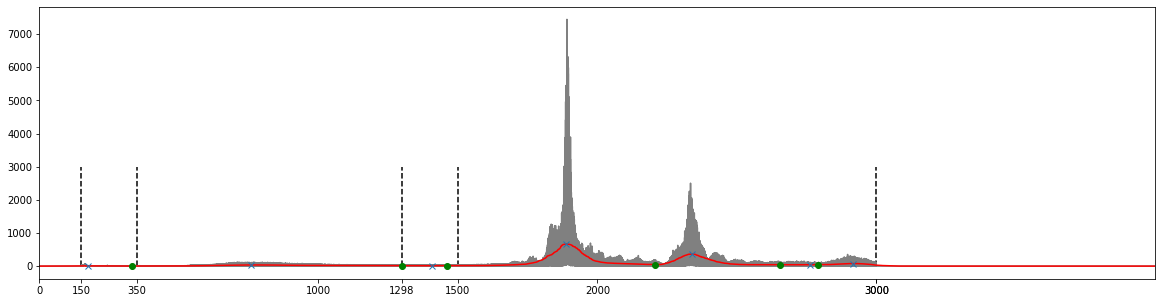

female lower bound:  350.0
female higher bound:  1298.421697176766


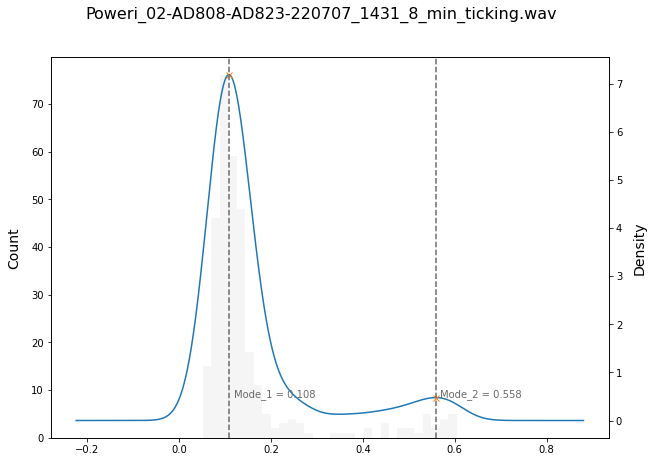

Mode_1:  0.10843047128757499
Mode_2:  0.5584077955506488


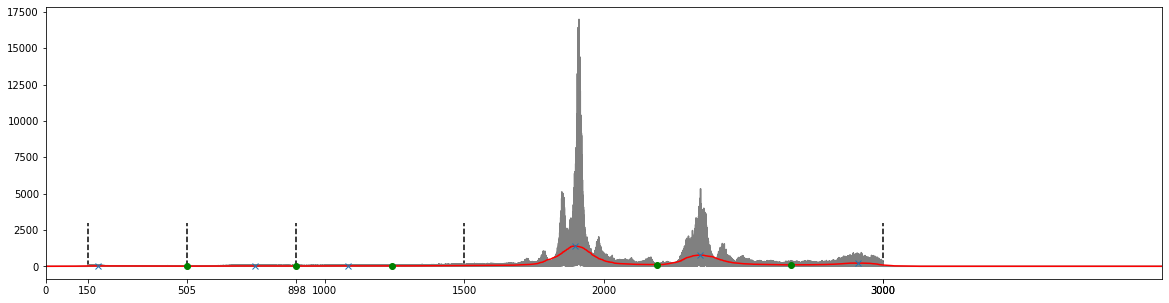

female lower bound:  504.8828831970909
female higher bound:  898.4022421836748


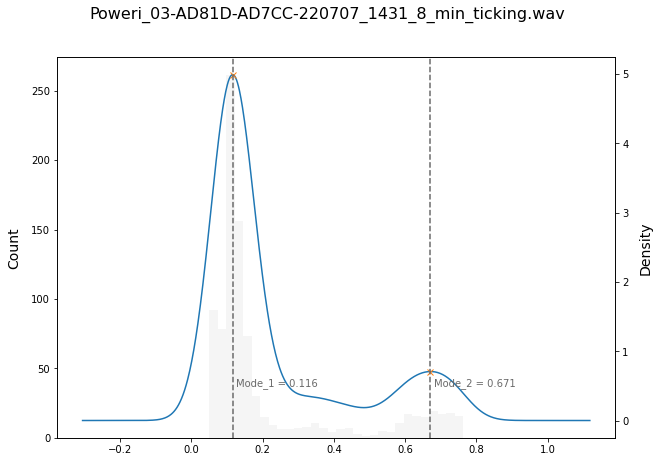

Mode_1:  0.11625346434871425
Mode_2:  0.6708287198763451


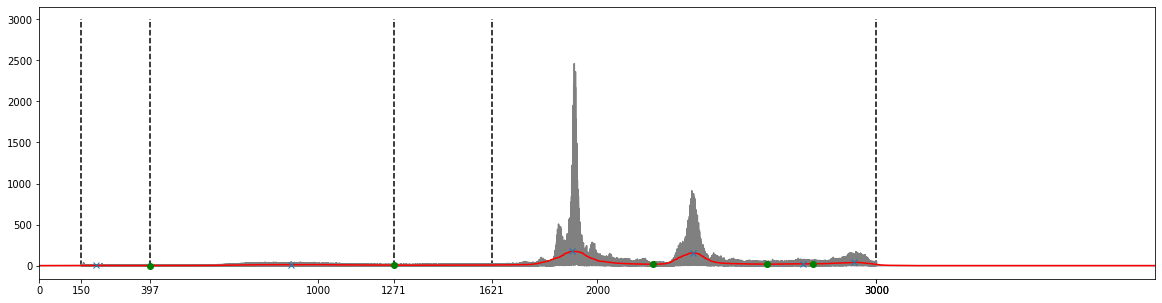

female lower bound:  396.99886780250256
female higher bound:  1270.5380936500044


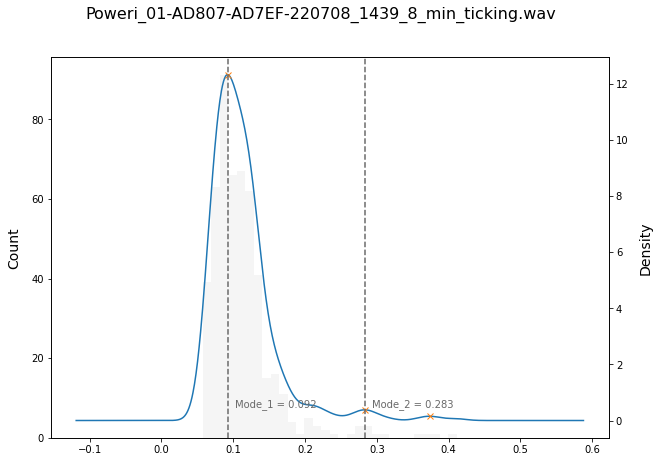

Mode_1:  0.0920241443257209
Mode_2:  0.283027392471827


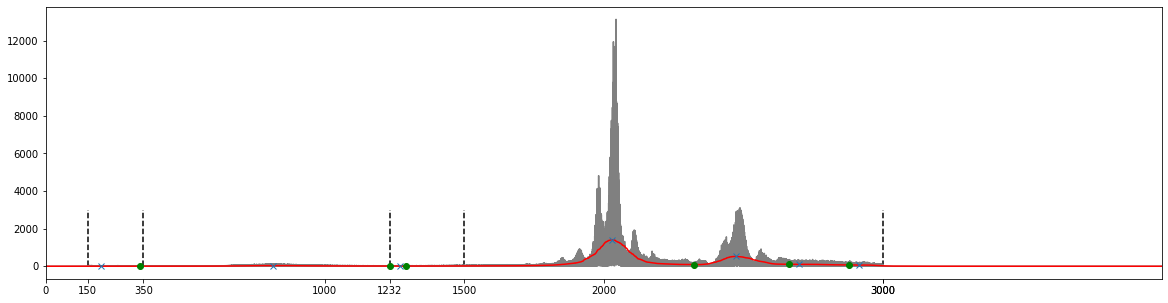

female lower bound:  350.0
female higher bound:  1232.3897465433


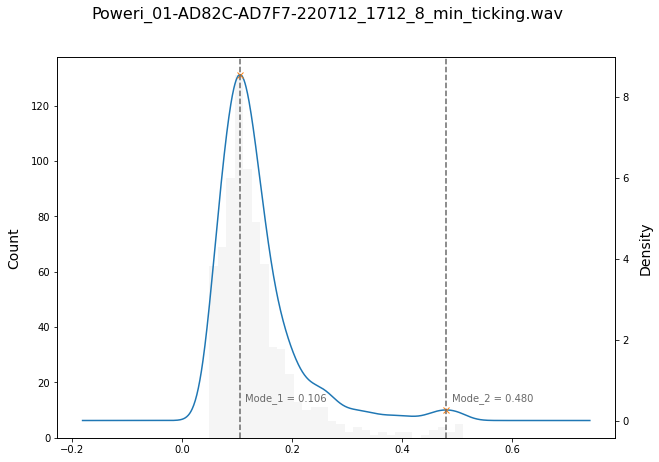

Mode_1:  0.1055382479985657
Mode_2:  0.47963488431742396


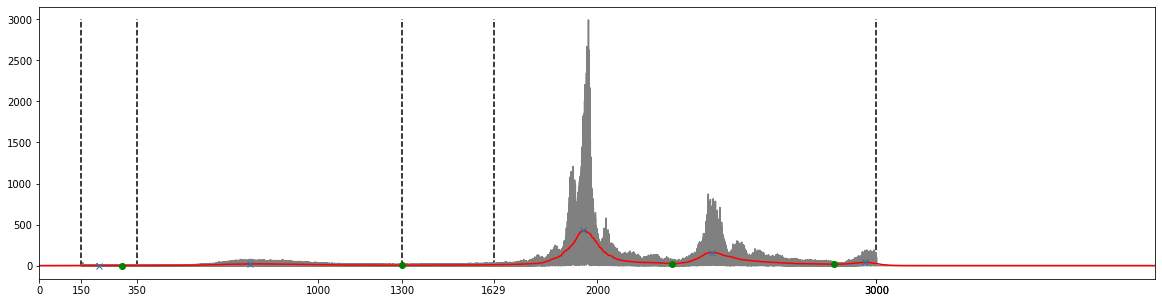

female lower bound:  350.0
female higher bound:  1300.0612540789436


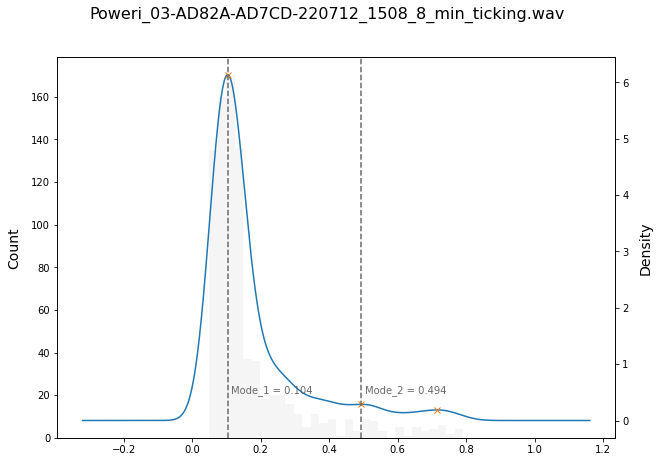

Mode_1:  0.10380006991117674
Mode_2:  0.4937998202283833


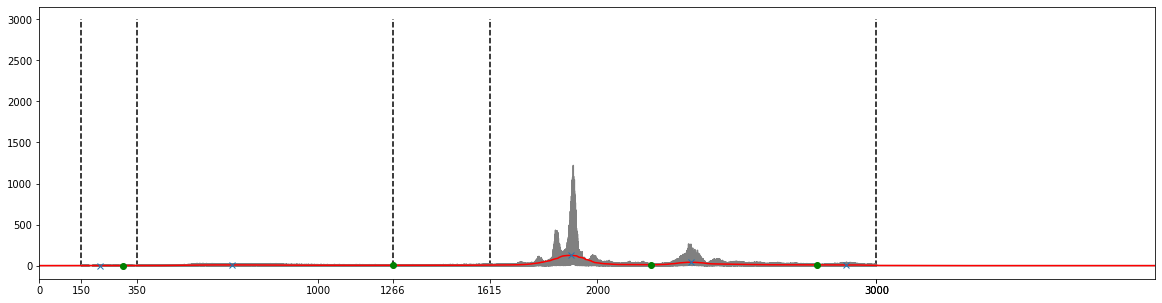

female lower bound:  350.0
female higher bound:  1266.38607565432


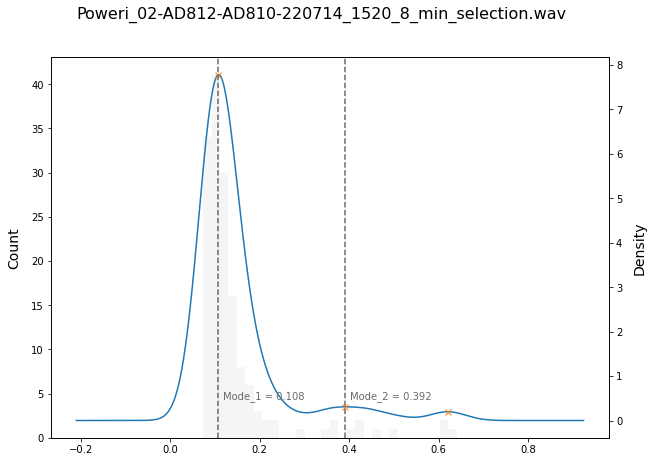

Mode_1:  0.10803647184599441
Mode_2:  0.3916534221296112


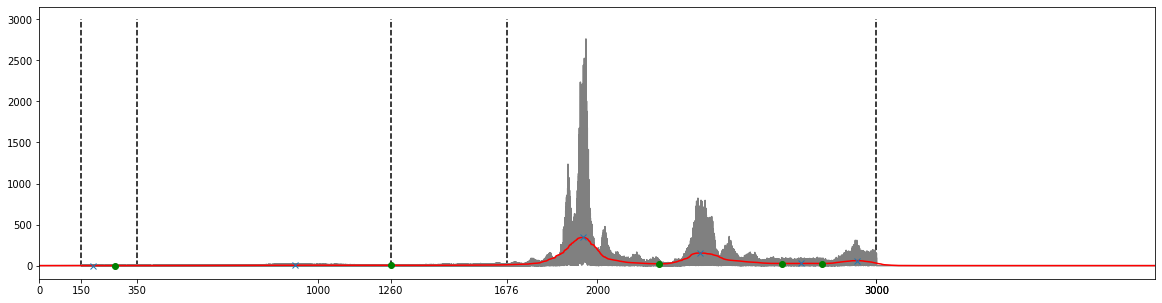

female lower bound:  350.0
female higher bound:  1259.83593535992


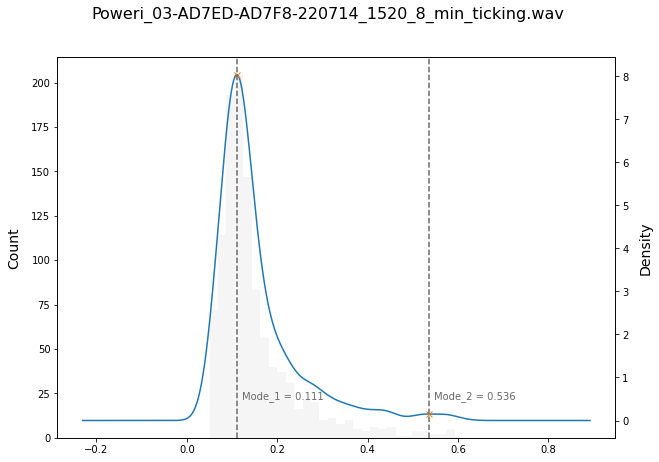

Mode_1:  0.11115984465191331
Mode_2:  0.5360418695339191


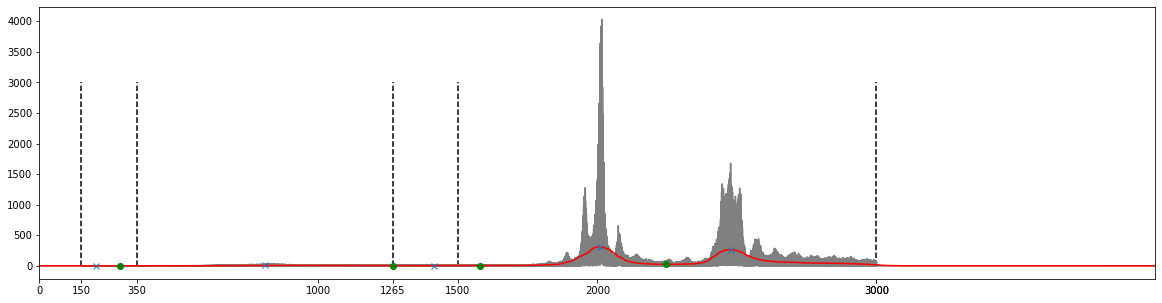

female lower bound:  350.0
female higher bound:  1265.4837892219928


In [ ]:
plot_execution('Poweri')

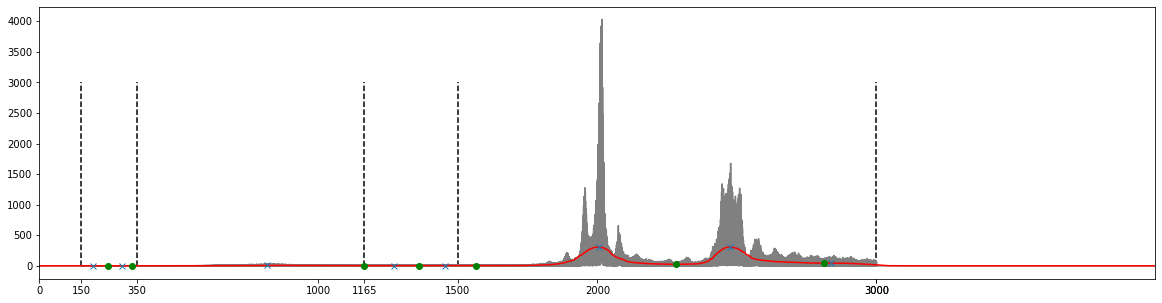

female lower bound:  350.0
female higher bound:  1164.5245046520415


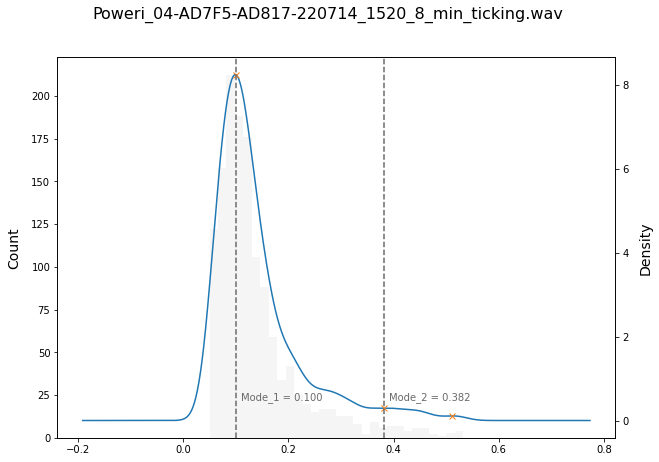

Mode_1:  0.09963133201228264
Mode_2:  0.3815044976949752


In [10]:
female_bimodal_plot('/content/drive/MyDrive/Ticking_8_min/Poweri_04-AD7F5-AD817-220714_1520_8_min_ticking.wav')

###Box plot for ticking